In [1]:
!pip install -q transformers

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import transformers
import urllib
import matplotlib.pyplot as plt

In [3]:
#  transformers.logging.set_verbosity_error()

In [4]:
# Extract training and test data
# For training data, we have about 3000 records from STS 2015
# For test data, we have about 9000 records which was given in STS 2016

def extract_data(X_train_path, y_train_path):
  tmp_df = pd.DataFrame(columns=['sent1', 'sent2', 'y'])
  response_X = urllib.request.urlopen(X_train_path)
  response_y = urllib.request.urlopen(y_train_path)

  for line_X, line_y in zip(response_X, response_y):
    if(line_y.decode('utf-8').strip()):
      tmp_df = tmp_df.append({'y' : line_y.decode('utf-8').strip(), 
                              'sent1' : line_X.decode("utf-8").strip().split('\t')[0],
                              'sent2' : line_X.decode("utf-8").strip().split('\t')[1]}, ignore_index=True)
  return tmp_df

def extract_test_data(X_train_path, category):
  tmp_df = pd.DataFrame(columns=['sent1', 'sent2', 'category'])
  response_X = urllib.request.urlopen(X_train_path)

  for line_X in response_X:
    tmp_df = tmp_df.append({'sent1' : line_X.decode("utf-8").strip().split('\t')[0],
                            'sent2' : line_X.decode("utf-8").strip().split('\t')[1],
                            'category' : category}, ignore_index=True)
  return tmp_df
  
  
train_df = pd.DataFrame(columns=['sent1', 'sent2', 'y'])
test_df = pd.DataFrame(columns=['sent1', 'sent2', 'category'])

train_df = train_df.append(extract_data('https://raw.githubusercontent.com/nee2shaji/STS-Task/main/data/STS.input.answers-forums.txt',
                                        'https://raw.githubusercontent.com/nee2shaji/STS-Task/main/data/STS.gs.answers-forums.txt'))
train_df = train_df.append(extract_data('https://raw.githubusercontent.com/nee2shaji/STS-Task/main/data/STS.input.answers-students.txt',
                                        'https://raw.githubusercontent.com/nee2shaji/STS-Task/main/data/STS.gs.answers-students.txt'))
train_df = train_df.append(extract_data('https://raw.githubusercontent.com/nee2shaji/STS-Task/main/data/STS.input.belief.txt',
                                        'https://raw.githubusercontent.com/nee2shaji/STS-Task/main/data/STS.gs.belief.txt'))
train_df = train_df.append(extract_data('https://raw.githubusercontent.com/nee2shaji/STS-Task/main/data/STS.input.headlines.txt',
                                        'https://raw.githubusercontent.com/nee2shaji/STS-Task/main/data/STS.gs.headlines.txt'))
train_df = train_df.append(extract_data('https://raw.githubusercontent.com/nee2shaji/STS-Task/main/data/STS.input.images.txt',
                                        'https://raw.githubusercontent.com/nee2shaji/STS-Task/main/data/STS.gs.images.txt'))

test_df = test_df.append(extract_test_data('https://raw.githubusercontent.com/nee2shaji/STS-Task/main/data/STS2016.input.answer-answer.txt', 0))
test_df = test_df.append(extract_test_data('https://raw.githubusercontent.com/nee2shaji/STS-Task/main/data/STS2016.input.headlines.txt', 1))
test_df = test_df.append(extract_test_data('https://raw.githubusercontent.com/nee2shaji/STS-Task/main/data/STS2016.input.plagiarism.txt', 2))
test_df = test_df.append(extract_test_data('https://raw.githubusercontent.com/nee2shaji/STS-Task/main/data/STS2016.input.postediting.txt', 3))
test_df = test_df.append(extract_test_data('https://raw.githubusercontent.com/nee2shaji/STS-Task/main/data/STS2016.input.question-question.txt', 4))

train_df = train_df.reset_index(drop=True)
train_df['y'] = train_df['y'].astype(float)

test_df = test_df.reset_index(drop=True)

train_df

,sent1,sent2,y
0,You'll need to check the particular policies o...,If you need to publish the book and you have f...,3.0
1,I am not aware of any university run participa...,At the universities I've worked in North Ameri...,0.6
2,Apart from admission (which normally should no...,Age is not a PhD admission facor in the contin...,1.0
3,This post refers to research in the STEM field...,This is about my experience in computer engine...,0.6
4,If you don't want to pay for Adobe Acrobat Pro...,"If you don't mind hosting your files online, S...",0.8
...,...,...,...
2995,A baseball player throws the ball.,The basketball player holds the ball.,1.6
2996,A man is swinging on a rope over water.,A man in a maroon bathing suit swings on a rop...,3.0
2997,A woman wearing large sunglasses holds newspap...,A fat woman wearing faint blue top is blowing ...,1.0
2998,A deer jumps a fence.,A deer is jumping over a fence.,5.0


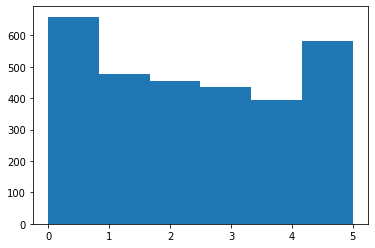

In [5]:
# Histogram plot of the train labels
plt.hist(train_df['y'], bins=6, range=(0, 5.0))
plt.show()
# type(train_df['y'][0])

In [6]:
# We round of each train label to nearest int
# The distribution of training data in all classes is almost the same
train_df['y'] = train_df['y'].apply(lambda x: round(x))
train_df['y'].value_counts()

2    583
1    571
3    528
4    469
0    440
5    409
Name: y, dtype: int64

In [7]:
test_df.shape

(9183, 3)

In [8]:
# The max length of sentence pair is calculated to be used for max_length parameter while tokenising
train_sent_len_list = [len(x.split())+len(y.split()) for x,y in zip(train_df['sent1'],train_df['sent2'])]
test_sent_len_list = [len(x.split())+len(y.split()) for x,y in zip(test_df['sent1'], test_df['sent2'])]
print(max(train_sent_len_list))
print(max(test_sent_len_list))

96
200


In [9]:
# Max length of sentence pair is 200. Hence we set max_length to 256
max_length = 256

In [10]:
# Tokenise the data as required by BERT model returning attention masks and token type ids
tokenizer = transformers.BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)
encoded = tokenizer.batch_encode_plus(
    train_df[["sent1", "sent2"]].values.astype("str").tolist(),
    add_special_tokens=True,
    max_length=max_length,
    return_attention_mask=True,
    return_token_type_ids=True,
    padding='max_length',
    truncation=True,
    return_tensors="tf")

input_ids = np.array(encoded["input_ids"], dtype="int32")
attention_masks = np.array(encoded["attention_mask"], dtype="int32")
token_type_ids = np.array(encoded["token_type_ids"], dtype="int32")

labels = tf.keras.utils.to_categorical(train_df['y'], num_classes=6)
labels = np.array(labels, dtype="int32")

In [11]:
print(input_ids[0])
print(attention_masks[0])
print(token_type_ids[0])
print(input_ids.shape)
print(attention_masks.shape)
print(token_type_ids.shape)
print(labels.shape)

[  101  2017  1005  2222  2342  2000  4638  1996  3327  6043  1997  2169
  6674  2000  2156  2054  2003  3039  1998  2054  2003  2025  3039  1012
   102  2065  2017  2342  2000 10172  1996  2338  1998  2017  2031  2179
  2028  6674  2008  4473  2009  1012   102     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

In [12]:
# Build the model

def build_sts_model():
  input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
  attention_masks = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="attention_masks")
  token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="token_type_ids")
  
  bert_model = transformers.TFBertModel.from_pretrained("bert-base-uncased")
  bert_model.trainable = False

  bert_output = bert_model(input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids)
  sequence_output = bert_output.last_hidden_state
  bi_lstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(sequence_output)
  bi_lstm2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(bi_lstm1)
  bi_lstm3 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(bi_lstm2)
  avg_pool = tf.keras.layers.GlobalAveragePooling1D()(bi_lstm3)
  dropout = tf.keras.layers.Dropout(0.3)(avg_pool)
  output = tf.keras.layers.Dense(6, activation="softmax")(dropout)
  model = tf.keras.models.Model(inputs=[input_ids, attention_masks, token_type_ids], outputs=output)
  
  model.compile(
      optimizer=tf.keras.optimizers.Adam(),
      loss="categorical_crossentropy",
      metrics=["acc"])
  
  return model


In [13]:
sts_model = build_sts_model()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [14]:
sts_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 256)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_masks[0][0]',    

In [15]:
# Train the model
history = sts_model.fit(
    x = [input_ids, attention_masks, token_type_ids], 
    y = labels,
    epochs=5,
    use_multiprocessing=True)

Epoch 1/5
94/94 [==============================] - 154s 1s/step - loss: 1.6044 - acc: 0.2970
Epoch 2/5
94/94 [==============================] - 128s 1s/step - loss: 1.3920 - acc: 0.3960
Epoch 3/5
94/94 [==============================] - 128s 1s/step - loss: 1.3197 - acc: 0.4207
Epoch 4/5
94/94 [==============================] - 128s 1s/step - loss: 1.2382 - acc: 0.4653
Epoch 5/5
94/94 [==============================] - 128s 1s/step - loss: 1.1842 - acc: 0.4887


In [16]:
# Tokenise test data and predict output

def get_encoded_test_data(tmp_df):
  encoded = tokenizer.batch_encode_plus(
      tmp_df[["sent1", "sent2"]].values.astype("str").tolist(),
      add_special_tokens=True,
      max_length=max_length,
      return_attention_mask=True,
      return_token_type_ids=True,
      padding='max_length',
      truncation=True,
      return_tensors="tf")
  
  input_ids = np.array(encoded["input_ids"], dtype="int32")
  attention_masks = np.array(encoded["attention_mask"], dtype="int32")
  token_type_ids = np.array(encoded["token_type_ids"], dtype="int32")

  return [input_ids, attention_masks, token_type_ids]

# Evaluation is done separately for each category, hence we output files for each category separately

sts_res = sts_model.predict(get_encoded_test_data(test_df[test_df['category']==0]))
# print(sts_res.shape)
# print(sts_res)
pd.Series(np.argmax(sts_res, axis=1)).to_csv('STS2016_output_answer-answer.txt', sep=' ', index=False, header=False)

sts_res = sts_model.predict(get_encoded_test_data(test_df[test_df['category']==1]))
pd.Series(np.argmax(sts_res, axis=1)).to_csv('STS2016_output_headlines.txt', sep=' ', index=False, header=False)

sts_res = sts_model.predict(get_encoded_test_data(test_df[test_df['category']==2]))
pd.Series(np.argmax(sts_res, axis=1)).to_csv('STS2016_output_plagiarism.txt', sep=' ', index=False, header=False)

sts_res = sts_model.predict(get_encoded_test_data(test_df[test_df['category']==3]))
pd.Series(np.argmax(sts_res, axis=1)).to_csv('STS2016_output_postediting.txt', sep=' ', index=False, header=False)

sts_res = sts_model.predict(get_encoded_test_data(test_df[test_df['category']==4]))
pd.Series(np.argmax(sts_res, axis=1)).to_csv('STS2016_output_question-question.txt', sep=' ', index=False, header=False)